In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
torch.set_default_dtype(torch.float32)

## Load data

In [2]:
mods = [transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,)),    #mean and std of MNIST
        transforms.Lambda(lambda x: torch.flatten(x))]
mods = transforms.Compose(mods)

trainset = datasets.MNIST(root='./data/train', train=True, download=True, transform=mods)
testset = datasets.MNIST(root='./data/test', train=False, download=True, transform=mods)

In [102]:
batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

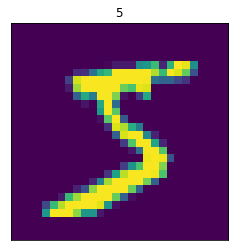

In [103]:
plt.imshow(trainset[0][0].reshape((28, 28)));
plt.title(trainset[0][1]);
plt.xticks([])
plt.yticks([]);

## Prepare a single network module

In [104]:
class SimpleNetwork(torch.nn.Module):
    def __init__(self, inp_size, layers=[100]):
        super().__init__()
        self.layers = []
        
        self.inp = torch.nn.Linear(inp_size, layers[0])
        self.output = torch.nn.Linear(layers[0], 10)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax()
    
    def forward(self, x):
        out = x
        out = self.inp(out)
        out = self.relu(out)
        out = self.output(out)
        return out

In [262]:
def train_net(net, optimizer, epochs, verbose=False):
    for epoch in range(epochs): 
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            correct += (outputs.argmax(1)==labels).float().sum()
            total += outputs.shape[0]
            running_loss += loss.item()
            if i % 100 == 0:    # print every 2000 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f acc: %.3f%%' %
                          (epoch + 1, i, running_loss / 100, correct/total*100))
                running_loss = 0.0
                correct = 0
                total=0

        correct = 0
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        print(f"Test acc: {correct/len(testset)*100}")
        
    return correct/len(testset)*100

### Benchmark

#### Full network

In [263]:
net = SimpleNetwork(784)

In [264]:
criterion = torch.nn.CrossEntropyLoss()

In [265]:
%%time
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3)
train_net(net, optimizer, 5)
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
final_loss = train_net(net, optimizer, 5)

Test acc: 95.54
Test acc: 96.95
Test acc: 97.18
Test acc: 97.23
Test acc: 96.71
Test acc: 97.94
Test acc: 97.98
Test acc: 97.99
Test acc: 98.11
Test acc: 98.00999999999999
CPU times: user 7min 20s, sys: 6.7 s, total: 7min 27s
Wall time: 2min 21s


#### Masked input (for further benchmark)

In [ ]:
class MaskedNetwork(SimpleNetwork):
    def __init__(self, input_size, mask_size, layers=[10]):
        super().__init__(mask_size, layers=layers)
        template = np.zeros(input_size)
        mask = np.random.choice(len(template), mask_size, False)
        template[mask] = 1
        self.mask = torch.from_numpy(template).to(torch.bool)
        
    def forward(self, x):
        data = x[:, self.mask]
        return super().forward(data)

masked_net = MaskedNetwork(784, 20)
optimizer = torch.optim.Adam(masked_net.parameters(), lr=3e-3)
train_net(masked_net, optimizer, 5)
optimizer = torch.optim.Adam(masked_net.parameters(), lr=3e-4)
train_net(masked_net, optimizer, 5)

Test acc: 52.239999999999995
Test acc: 53.769999999999996
Test acc: 54.190000000000005
Test acc: 54.85
Test acc: 54.26
Test acc: 54.730000000000004
Test acc: 54.72
Test acc: 54.81
Test acc: 54.879999999999995
Test acc: 54.81


54.81

## Create simple network with insertable weights

In [266]:
flat_parameters = []
for layer in net.parameters():
    flat_parameters.extend(torch.flatten(layer).detach().numpy())
    
flat_parameters = torch.from_numpy(np.array(flat_parameters))

In [317]:
import torch.nn.functional as F

class InsertableNet(SimpleNetwork):
    def __init__(self, weights, inp_size, layers=[100]):
        super().__init__(inp_size, layers)
        input_w_size = inp_size*layers[0]
        input_b_size = layers[0]

        hidden_w_size = layers[0]*10
        hidden_b_size = 10

        self.inp_weights = weights[:input_w_size].reshape((layers[0], inp_size))
        self.inp_bias = weights[input_w_size:input_w_size+input_b_size]

        self.output_weights = weights[input_w_size+input_b_size:input_w_size+input_b_size+hidden_w_size].reshape((10, layers[0]))
        self.output_bias = weights[input_w_size+input_b_size+hidden_w_size:input_w_size+input_b_size+hidden_w_size+hidden_b_size]

#         self.inp.weight = self.inp_weights
#         self.inp.bias = torch.nn.Parameter(inp_bias, requires_grad=True)
#         self.output.weight = torch.nn.Parameter(output_weights, requires_grad=True)
#         self.output.bias = torch.nn.Parameter(output_bias, requires_grad=True)        
    
    def forward(self, data):
        # Yeah, this is hardly scalable so we need to find a way
        # to make the layer-wise approach work
        out = F.linear(data, self.inp_weights, self.inp_bias)
        out = self.relu(out)
        out = F.linear(out, self.output_weights, self.output_bias)
        return out

In [318]:
insert_net = InsertableNet(flat_parameters, 784)

In [319]:
correct = 0
for data in testloader:
    images, labels = data
    outputs = insert_net(images)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()
print(f"Test acc: {correct/len(testset)*100}")
assert correct/len(testset)*100 == final_loss

Test acc: 98.00999999999999


## Create hypernet structure

In [330]:
class Hypernetwork(torch.nn.Module):
    def __init__(self, inp_size=784, mask_size=20, node_hidden_size=20):
        super().__init__()
        self.mask_size = mask_size
        self.input_size = inp_size
        self.node_hidden_size = node_hidden_size
        
        input_w_size = mask_size*node_hidden_size
        input_b_size = node_hidden_size

        hidden_w_size = node_hidden_size*10
        hidden_b_size = 10
            
        self.out_size = input_w_size+input_b_size+hidden_w_size+hidden_b_size
        
        self.input = torch.nn.Linear(inp_size, 256)
        self.hidden1 = torch.nn.Linear(256, 512)
        self.hidden2 = torch.nn.Linear(512, 1024)
        self.out = torch.nn.Linear(1024, self.out_size)
        
        self.relu = torch.nn.ReLU()
        self.template = np.zeros(inp_size)
        
    def forward(self, data, mask=None):
        if mask is None:
            mask = np.random.choice(len(template), self.mask_size, False)
            tmp = self.template.copy()
            tmp[mask] = 1
            mask = torch.from_numpy(tmp).to(torch.float32)
        
        weights = self.craft_network(mask)
        nn = InsertableNet(weights, self.mask_size, layers=[self.node_hidden_size])
        masked_data = data[:, mask.to(torch.bool)]
        return nn(masked_data)
        
    def craft_network(self, mask):
        out = self.input(mask)
        out = self.relu(out)
        out = self.hidden1(out)
        out = self.relu(out)
        out = self.hidden2(out)
        out = self.relu(out)
        out = self.out(out)
        return out

In [331]:
from torchsummary import summary

In [332]:
hypernet = Hypernetwork(mask_size=20)

In [333]:
list(hypernet.parameters())[0]

Parameter containing:
tensor([[ 0.0319, -0.0348, -0.0029,  ...,  0.0254, -0.0344,  0.0133],
        [ 0.0313,  0.0180,  0.0310,  ...,  0.0021,  0.0039, -0.0089],
        [-0.0063,  0.0307, -0.0229,  ...,  0.0071,  0.0080,  0.0203],
        ...,
        [-0.0156,  0.0212, -0.0279,  ...,  0.0324,  0.0294, -0.0188],
        [-0.0143, -0.0207,  0.0297,  ..., -0.0014,  0.0147, -0.0123],
        [ 0.0084,  0.0326, -0.0354,  ..., -0.0154,  0.0326,  0.0024]],
       requires_grad=True)

In [334]:
summary(hypernet, (784, ), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                       [-1]         200,960
              ReLU-2                       [-1]               0
            Linear-3                       [-1]         131,584
              ReLU-4                       [-1]               0
            Linear-5                       [-1]         525,312
              ReLU-6                       [-1]               0
            Linear-7                       [-1]         645,750
Total params: 1,503,606
Trainable params: 1,503,606
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 5.74
Estimated Total Size (MB): 5.74
----------------------------------------------------------------


In [335]:
optimizer = torch.optim.Adam(hypernet.parameters(), lr=3e-4)
train_net(hypernet, optimizer, 1, verbose=True);

[1,     0] loss: 0.023 acc: 10.938%
[1,   100] loss: 2.253 acc: 16.422%
[1,   200] loss: 2.223 acc: 18.234%
[1,   300] loss: 2.218 acc: 17.547%
[1,   400] loss: 2.216 acc: 18.203%
[1,   500] loss: 2.205 acc: 18.609%
[1,   600] loss: 2.201 acc: 19.109%
[1,   700] loss: 2.197 acc: 19.688%
[1,   800] loss: 2.205 acc: 18.938%
[1,   900] loss: 2.208 acc: 18.766%
Test acc: 19.689999999999998


19.689999999999998

In [307]:
list(hypernet.parameters())[0]

Parameter containing:
tensor([[ 0.0007, -0.0386, -0.0152,  ..., -0.0046,  0.0250,  0.0389],
        [-0.0277, -0.0089, -0.0113,  ..., -0.0275, -0.0334, -0.0289],
        [-0.0218, -0.0114,  0.0033,  ...,  0.0250, -0.0010, -0.0237],
        ...,
        [ 0.0278,  0.0275, -0.0091,  ...,  0.0253, -0.0248, -0.0152],
        [ 0.0008, -0.0292, -0.0228,  ...,  0.0315, -0.0322, -0.0262],
        [ 0.0154, -0.0110,  0.0032,  ...,  0.0054, -0.0130,  0.0310]],
       requires_grad=True)

## Conclusion
The network is able to train, so everything is working as expected. Now, we can focus on the raw score optimization.